In [ ]:
from functools import partial
import typing
import jax
import jax.numpy as jnp
import flax.linen as nn
import inspeqtor.experimental as sq
from helper import get_gaussian_pulse_sequence
import pandas as pd
import matplotlib.pyplot as plt
from helper import get_data_model

jax.config.update("jax_enable_x64", True)

In [ ]:
def noisy_quantum_device(
    pulse_parameters: jnp.ndarray,
    noisy_simulator: typing.Callable[[jnp.ndarray], jnp.ndarray],
) -> jnp.ndarray:
    unitaries = jax.vmap(noisy_simulator)(pulse_parameters)
    return sq.utils.calculate_expectation_values(unitaries[:, -1, :, :])


def create_custom_activation_fn(pulse_sequence: sq.pulse.PulseSequence):
    _, params_array_fn = sq.pulse.get_param_array_converter(pulse_sequence)

    lower, upper = pulse_sequence.get_bounds()

    upper_vec = params_array_fn(upper)
    lower_vec = params_array_fn(lower)

    def custom_activation_fn(x: jnp.ndarray):
        return ((upper_vec - lower_vec) * nn.sigmoid(x)) + lower_vec

    return custom_activation_fn


def graybox_fn(
    pulse_paramters: jnp.ndarray,
    blackbox_fn: typing.Callable[[jnp.ndarray], sq.typing.Wos],
    whitebox_fn: typing.Callable[[jnp.ndarray], jnp.ndarray],
) -> jnp.ndarray:
    Wos = blackbox_fn(pulse_paramters)
    unitaries = jax.vmap(whitebox_fn)(pulse_paramters)[:, -1, :, :]

    return sq.model.get_predict_expectation_value(
        Wos, unitaries, sq.constant.default_expectation_values_order
    )


def loss_fn(
    params: sq.model.VariableDict,
    pulse_parameters: jnp.ndarray,
    expectation_values: jnp.ndarray,
    model: nn.Module,
    quantum_device: typing.Callable,
):
    correction_vec = model.apply(params, pulse_parameters)

    predicted_expectation_values = quantum_device(correction_vec)

    return jnp.mean(
        jax.vmap(sq.model.mse, in_axes=(0, 0))(
            expectation_values, predicted_expectation_values
        )
    )


def loss_fn_v2(
    params: sq.model.VariableDict,
    pulse_parameters: jnp.ndarray,
    unitaries: jnp.ndarray,
    model: nn.Module,
    quantum_device: typing.Callable,
):
    correction_vec = model.apply(params, pulse_parameters)

    # graybox function should be a function that take pulse parameters
    # and return the expectation values.
    predicted_expectation_values = quantum_device(correction_vec)

    coeffs = jax.vmap(sq.physics.direct_AFG_estimation_coefficients)(unitaries)
    AGF = jax.vmap(sq.physics.direct_AFG_estimation)(
        coeffs, predicted_expectation_values
    )

    return jnp.mean(jnp.abs(AGF - 1))


def loss_fn_v3(
    params: sq.model.VariableDict,
    pulse_parameters: jnp.ndarray,
    unitaries: jnp.ndarray,
    expectation_values: jnp.ndarray,
    model: nn.Module,
    quantum_device: typing.Callable,
):
    correction_vec = model.apply(params, pulse_parameters)

    expectation_values_pred = quantum_device(correction_vec)

    # # This is the target unitary
    coefficients = jax.vmap(sq.physics.direct_AFG_estimation_coefficients)(unitaries)

    diff = jnp.abs(expectation_values - expectation_values_pred)

    AGF = jax.vmap(sq.physics.direct_AFG_estimation)(
        coefficients, expectation_values_pred
    )

    return jnp.mean(jnp.abs(coefficients) * diff), (
        AGF,
        jax.vmap(sq.physics.direct_AFG_estimation)(
            coefficients, quantum_device(pulse_parameters)
        ),
    )

    # return metrics[sq.model.LossMetric.WAEE], metrics


def polynomial_feature_map(x: jnp.ndarray, degree: int):
    return jnp.concatenate([x**i for i in range(1, degree + 1)], axis=-1)


class MLP(nn.Module):
    # Simple flax MLP model
    layers: list[int]
    feature_size: int
    activation_fn: typing.Callable

    @nn.compact
    def __call__(self, x):
        for i, hidden in enumerate(self.layers):
            x = nn.Dense(hidden)(x)
            x = nn.leaky_relu(x)
        x = nn.Dense(self.feature_size)(x)
        x = self.activation_fn(x)
        return x

In [ ]:
key = jax.random.key(0)
key, data_key, model_key, train_key, gate_optim_key = jax.random.split(key, 5)
sample_size = 1000
shots = 3000
data_model = get_data_model()
qubit_info = sq.predefined.get_mock_qubit_information()
whitebox = sq.predefined.get_single_qubit_whitebox(
    hamiltonian=data_model.ideal_hamiltonian,
    pulse_sequence=data_model.pulse_sequence,
    qubit_info=qubit_info,
    dt=data_model.dt,
)


def get_pulse_sequence_fn():
    return sq.predefined.get_drag_pulse_sequence(qubit_info)


def get_pulse_sequence_fn_v2():
    return get_gaussian_pulse_sequence(qubit_info)


exp_data, pulse_sequence, unitaries, noisy_simulator = (
    sq.predefined.generate_experimental_data(
        key=data_key,
        hamiltonian=data_model.total_hamiltonian,
        sample_size=sample_size,
        shots=shots,
        strategy=sq.predefined.SimulationStrategy.SHOT,
        get_qubit_information_fn=lambda: data_model.qubit_information,
        get_pulse_sequence_fn=lambda: data_model.pulse_sequence,
    )
)

loaded_data = sq.utils.prepare_data(
    exp_data=exp_data, pulse_sequence=pulse_sequence, whitebox=whitebox
)

/var/folders/rm/_5r9_x2s3tgfyqlnv1pdjfqc0000gn/T/ipykernel_82473/2197013390.py:17: UserWarning: The function generate_mock_experiment_data is not yet tested.
  sq.predefined.generate_mock_experiment_data(
/Users/porametpathumsoot/University/PhD/Projects/espresso/inspeqtor/.venv/lib/python3.11/site-packages/equinox/_jit.py:55: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
  out = fun(*args, **kwargs)
/Users/porametpathumsoot/University/PhD/Projects/espresso/inspeqtor/.venv/lib/python3.11/site-packages/equinox/_jit.py:55: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
  out = fun(*args, **kwargs)


In [ ]:
key = jax.random.key(0)
key, random_split_key_1, random_split_key_2, train_key, prediction_key = (
    jax.random.split(key, 5)
)
(
    train_p,
    train_u,
    train_e,
    eval_p,
    eval_u,
    eval_ex,
) = sq.utils.random_split(
    random_split_key_1,
    100,  # Test size
    loaded_data.pulse_parameters,
    loaded_data.unitaries,
    loaded_data.expectation_values,
)

(val_p, val_u, val_ex, test_p, test_u, test_ex) = sq.utils.random_split(
    random_split_key_2, 50, eval_p, eval_u, eval_ex
)

In [ ]:
metric = sq.model.LossMetric.MSEE

model = sq.model.make_basic_blackbox_model(
    # unitary_activation_fn=lambda x: 2 * jnp.pi * (jnp.cos(x) + 1) / 2,
    # diagonal_activation_fn=lambda x: jnp.cos(x),
    # unitary_activation_fn = lambda x: (2 * jnp.pi * nn.hard_sigmoid(x)) + 1e-3,
    # diagonal_activation_fn = lambda x: ((2 * nn.hard_sigmoid(x)) - 1) + 1e-3,
)

trainable = sq.optimize.default_trainable_v3(
    pulse_sequence=loaded_data.pulse_sequence,
    metric=metric,
    experiment_identifier="test",
    hamiltonian=sq.predefined.rotating_transmon_hamiltonian,
    model_choice=model,
)

results = sq.optimize.hypertuner(
    trainable=trainable,
    train_pulse_parameters=polynomial_feature_map(train_p, 4),
    train_unitaries=train_u,
    train_expectation_values=train_e,
    test_pulse_parameters=polynomial_feature_map(test_p, 4),
    test_unitaries=test_u,
    test_expectation_values=test_ex,
    val_pulse_parameters=polynomial_feature_map(val_p, 4),
    val_unitaries=val_u,
    val_expectation_values=val_ex,
    train_key=train_key,
    num_samples=1,
    search_algo=sq.optimize.SearchAlgo.OPTUNA,
    metric=metric,
    search_spaces={
        "hidden_layer_1_1": (0, 1),  # (0, 1) means no hidden layer
        "hidden_layer_1_2": (0, 1),  # (0, 1) means no hidden layer
        "hidden_layer_2_1": (0, 1),  # (0, 1) means no hidden layer
        "hidden_layer_2_2": (4, 5),
    },
)

model_state, train_hist, data_config = sq.optimize.get_best_hypertuner_results(
    results, metric=metric
)

2024-12-18 19:04:19,127	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/porametpathumsoot/ray_results/tune_experiment' in 0.0188s.
2024-12-18 19:04:19,131	INFO tune.py:1041 -- Total run time: 123.41 seconds (123.37 seconds for the tuning loop).
2024-12-18 19:04:19,131	INFO tune.py:1041 -- Total run time: 123.41 seconds (123.37 seconds for the tuning loop).


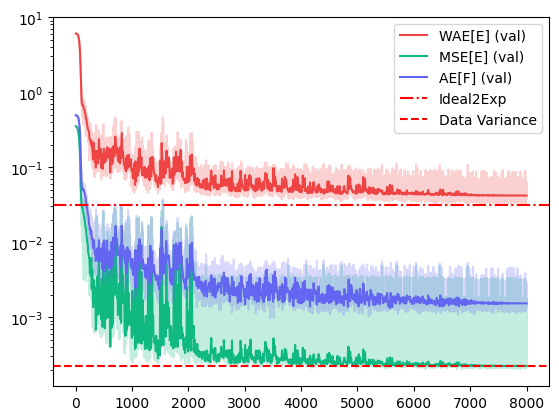

In [ ]:
APPLY_TRANSFORM = False
dataset_metric = sq.utils.get_dataset_metrics(loaded_data)

hist_df = pd.DataFrame(train_hist)
train_hist_df = hist_df[hist_df["loop"] == "train"]
val_hist_df = hist_df[hist_df["loop"] == "test"]

# with plt.style.context('science'):

fig, ax = plt.subplots()

colors = ["#ef4444", "#10b981", "#6366f1"]

x_val = val_hist_df["step"].to_numpy()
x_train = train_hist_df["step"].to_numpy()
metrics = [
    sq.optimize.LossMetric.WAEE,
    sq.optimize.LossMetric.MSEE,
    sq.optimize.LossMetric.AEF,
]
for color, metric in zip(colors, metrics):
    y_val = val_hist_df[metric.value].to_numpy()
    y_train = train_hist_df[metric.value].to_numpy()

    if metric == sq.optimize.LossMetric.AEF and APPLY_TRANSFORM:
        # This transformation is to check that transformed AE[F] always lower than MSE[E]
        y_val = (4 / 3) * y_val**2
        y_train = (4 / 3) * y_train**2

    # rolling
    ax.plot(
        x_train, y_train, alpha=0.25, color=color
    )  # , label=f"{metric.name} (train)"
    ax.plot(x_val, y_val, label=f"{metric.value} (val)", color=color)

# Plot the hline using dataset metrics
ax.axhline(dataset_metric.mse_ideal2exp, color="r", linestyle="-.", label="Ideal2Exp")
ax.axhline(dataset_metric.var, color="r", linestyle="--", label="Data Variance")
ax.legend()
# Log scale
ax.set_yscale("log")

In [16]:
pulse_sequence = loaded_data.pulse_sequence
qubit_info = loaded_data.experiment_data.experiment_config.qubits[0]

dt = loaded_data.experiment_data.experiment_config.device_cycle_time_ns
t_eval = jnp.linspace(
    0,
    pulse_sequence.pulse_length_dt * dt,
    pulse_sequence.pulse_length_dt,
)

hamiltonian = partial(
    sq.predefined.rotating_transmon_hamiltonian,
    qubit_info=qubit_info,
    signal=sq.physics.signal_func_v5(
        sq.predefined.get_envelope_transformer(pulse_sequence=pulse_sequence),
        qubit_info.frequency,
        dt,
    ),
)

whitebox = sq.physics.make_trotterization_whitebox(
    hamiltonian, pulse_sequence, dt, pulse_sequence.pulse_length_dt
)
jax.vmap(whitebox)(loaded_data.pulse_parameters).shape

(1000, 320, 2, 2)

### Artificial data


In [17]:
def RXGate(theta: jnp.ndarray) -> jnp.ndarray:
    return jnp.array(
        [
            [jnp.cos(theta / 2), -1j * jnp.sin(theta / 2)],
            [-1j * jnp.sin(theta / 2), jnp.cos(theta / 2)],
        ]
    )

In [ ]:
subkey = jax.random.key(0)

data_theta = jax.random.uniform(subkey, (1_000,), minval=0, maxval=2 * jnp.pi)
print(data_theta[0])
data_unitaraies = jax.vmap(RXGate)(data_theta)
data_theta = data_theta.reshape(-1, 1)
# data_theta = polynomial_feature_map(data_theta / (2 * jnp.pi), 4)

# Calculate the expectation values
data_expectation_values = sq.utils.calculate_expectation_values(data_unitaraies)

data_theta.shape, data_unitaraies.shape, data_expectation_values.shape

3.826415750993364


((1000, 1), (1000, 2, 2), (1000, 18))

In [ ]:
key = jax.random.key(0)
key, random_split_key, correcter_key, train_key = jax.random.split(key, 4)

(
    train_pulse_parameters,
    train_unitaries,
    train_expectation_values,
    test_pulse_parameters,
    test_unitaries,
    test_expectation_values,
) = sq.utils.random_split(
    random_split_key,
    int(0.1 * data_theta.shape[0]),  # Test size
    data_theta,
    data_unitaraies,
    data_expectation_values,
)

activation_fn = create_custom_activation_fn(pulse_sequence)

correcter = MLP(
    layers=[20],
    feature_size=data_theta.shape[-1],
    activation_fn=activation_fn,
)
param = correcter.init(correcter_key, data_theta[0:1])


SAMPLE_SIZE = train_pulse_parameters.shape[0]
BATCH_SIZE = int(SAMPLE_SIZE * 0.1)
NUM_EPOCHS = 100

optimizer = sq.optimize.get_default_optimizer(8 * NUM_EPOCHS)
# optimizer = optax.adam(learning_rate=1e-3)

optimizer_state = optimizer.init(param)

blackbox = sq.model.BasicBlackBoxV2(**model_state.model_config)


def blackbox_fn(x: jnp.ndarray) -> sq.typing.Wos:
    # Polynomial Features
    x = polynomial_feature_map(x / (2 * jnp.pi), 4)
    return blackbox.apply(model_state.model_params, x)


def partial_loss_fn_v2(params, pulse_parameters, unitaries):
    return loss_fn_v2(
        params,
        pulse_parameters,
        unitaries,
        correcter,
        partial(graybox_fn, blackbox_fn=blackbox_fn, whitebox_fn=whitebox),
        # partial(noisy_quantum_device, noisy_simulator=noisy_simulator),
    )


def partial_loss_fn_v3(params, pulse_parameters, unitaries, expectation_values):
    return loss_fn_v3(
        params,
        pulse_parameters,
        unitaries,
        expectation_values,
        correcter,
        partial(graybox_fn, blackbox_fn=blackbox_fn, whitebox_fn=whitebox),
        # partial(noisy_quantum_device, noisy_simulator=noisy_simulator),
    )


def noisy_simulator_eval(
    params: sq.model.VariableDict,
    pulse_parameters: jnp.ndarray,
    unitaries: jnp.ndarray,
    quantum_device: typing.Callable,
):
    correction_vec = correcter.apply(params, pulse_parameters)

    # Evaluate the noisy simulator
    corrected_expectation_value = quantum_device(correction_vec)

    non_correction_pred = quantum_device(pulse_parameters)

    coeffs = jax.vmap(sq.physics.direct_AFG_estimation_coefficients)(unitaries)

    cAGF = jax.vmap(sq.physics.direct_AFG_estimation)(
        coeffs, corrected_expectation_value
    )

    ncAGF = jax.vmap(sq.physics.direct_AFG_estimation)(coeffs, non_correction_pred)

    return cAGF, ncAGF


def partial_noisy_simulator_eval(params, pulse_parameters, unitaries):
    return noisy_simulator_eval(
        params,
        pulse_parameters,
        unitaries,
        partial(noisy_quantum_device, noisy_simulator=noisy_simulator),
    )


train_step, test_step = sq.utils.create_step(
    optimizer, partial_loss_fn_v3, has_aux=True
)

loss_history = []

for (step, batch_idx, is_last_batch, epoch_idx), (
    batch_pulse_parameters,
    batch_unitaries,
    batch_expectation_values,
) in sq.utils.dataloader(
    (train_pulse_parameters, train_unitaries, train_expectation_values),
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    key=train_key,
):
    step += 1

    param, optimizer_state, (loss, _) = train_step(
        param,
        optimizer_state,
        batch_pulse_parameters,
        batch_unitaries,
        batch_expectation_values,
    )

    loss_history.append({"step": step, "loss": loss, "type": "train"})

    if is_last_batch:
        (test_loss, (correction_pred, non_correction_pred)) = test_step(
            param, test_pulse_parameters, test_unitaries, test_expectation_values
        )

        cAGF, ncAGF = partial_noisy_simulator_eval(
            param, test_pulse_parameters, test_unitaries
        )

        print(
            f"Step {step}, Loss: {test_loss:4f}, CE[AGF] {jnp.mean(correction_pred):4f}, NCE[AGF] {jnp.mean(non_correction_pred):4f}, Real cAGF {jnp.mean(cAGF):4f}, Real ncAGF {jnp.mean(ncAGF):4f}"
        )
        loss_history.append(
            {
                "step": step,
                "loss": test_loss,
                "type": "test",
            }
        )

        # Terminate at a certain threshold
        if jnp.mean(cAGF) > jnp.mean(ncAGF):
            break

Step 10, Loss: 0.359755, CE[AGF] 0.484789, NCE[AGF] 0.989114, Real cAGF 0.484607, Real ncAGF 0.994396
Step 20, Loss: 0.350062, CE[AGF] 0.500611, NCE[AGF] 0.989114, Real cAGF 0.500555, Real ncAGF 0.994396
Step 30, Loss: 0.300364, CE[AGF] 0.579319, NCE[AGF] 0.989114, Real cAGF 0.579481, Real ncAGF 0.994396
Step 40, Loss: 0.198156, CE[AGF] 0.755289, NCE[AGF] 0.989114, Real cAGF 0.755557, Real ncAGF 0.994396
Step 50, Loss: 0.184683, CE[AGF] 0.773110, NCE[AGF] 0.989114, Real cAGF 0.773425, Real ncAGF 0.994396
Step 60, Loss: 0.181012, CE[AGF] 0.786872, NCE[AGF] 0.989114, Real cAGF 0.787171, Real ncAGF 0.994396
Step 70, Loss: 0.140145, CE[AGF] 0.848824, NCE[AGF] 0.989114, Real cAGF 0.849180, Real ncAGF 0.994396
Step 80, Loss: 0.097669, CE[AGF] 0.921467, NCE[AGF] 0.989114, Real cAGF 0.921956, Real ncAGF 0.994396
Step 90, Loss: 0.039568, CE[AGF] 0.984043, NCE[AGF] 0.989114, Real cAGF 0.987640, Real ncAGF 0.994396
Step 100, Loss: 0.022430, CE[AGF] 0.992152, NCE[AGF] 0.989114, Real cAGF 0.989253,